# Quickstart: Live Data via yfinance

This notebook is a light, end-to-end example using the automated yfinance
connector. It is intentionally shorter than the CSV demos.

If you want a full method tour, see:
- `examples/aapl_volcurve_probcurve_demo.ipynb`
- `examples/aapl_volsurface_probsurface_demo.ipynb`

## Setup

Note: This notebook requires an active internet connection.

In [1]:
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from oipd import VolCurve, VolSurface, MarketInputs, sources

## Fetch a single-expiry chain

In [2]:
ticker = "AAPL"

# List available expiries
expiries = sources.list_expiry_dates(ticker)
expiries[:5]

['2026-02-04', '2026-02-06', '2026-02-09', '2026-02-11', '2026-02-13']

In [3]:
# Use the first expiry for a single-expiry VolCurve
single_expiry = expiries[0]
chain, snapshot = sources.fetch_chain(ticker, expiries=single_expiry)

market = MarketInputs(
    valuation_date=snapshot.date,
    risk_free_rate=0.04,
    underlying_price=snapshot.underlying_price,
)

curve = VolCurve().fit(chain, market)

{
    "expiry": single_expiry,
    "forward_price": curve.forward_price,
    "atm_vol": curve.atm_vol,
}

/Users/henrytian/Coding Projects/Github/probabilistic/oipd/interface/volatility.py:169: UserWarning: Filled 19 missing mid prices with last_price due to unavailable bid/ask
  warnings.warn(
/Users/henrytian/Coding Projects/Github/probabilistic/oipd/interface/volatility.py:182: UserWarning: Filtered 5 option rows (covering 5 strikes) older than 3 days (most recent: 4 days old, oldest: 6 days old)
  warnings.warn(


{'expiry': '2026-02-04',
 'forward_price': 271.385151789139,
 'atm_vol': 0.2996775493743432}

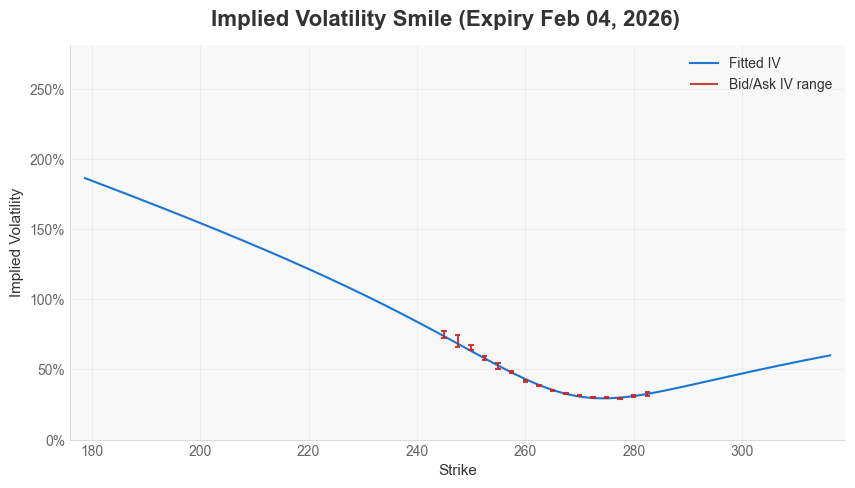

In [4]:
curve.plot(include_observed=True)
plt.show()

## ProbCurve quick check

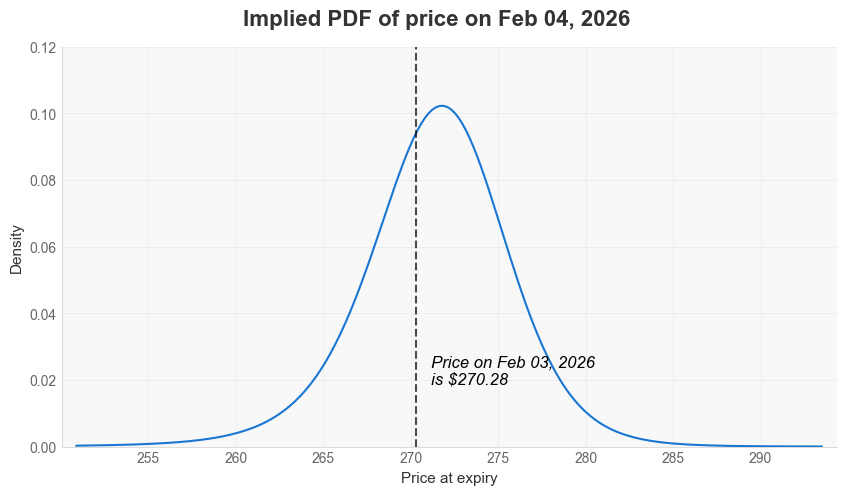

In [5]:
prob_curve = curve.implied_distribution()
prob_curve.plot(kind="pdf")
plt.show()

## Fetch multiple expiries and fit a VolSurface

In [6]:
surface_expiries = expiries[:3]
chain_surface, snapshot_surface = sources.fetch_chain(ticker, expiries=surface_expiries)

surface_market = MarketInputs(
    valuation_date=snapshot_surface.date,
    risk_free_rate=0.04,
    underlying_price=snapshot_surface.underlying_price,
)

surface = VolSurface().fit(chain_surface, surface_market)

surface.expiries

/Users/henrytian/Coding Projects/Github/probabilistic/oipd/pipelines/vol_surface/svi_slices.py:115: UserWarning: Filled missing mid prices with last_price for 3 expiries: [2026-02-04, 2026-02-06, 2026-02-09]
  warnings.warn(
/Users/henrytian/Coding Projects/Github/probabilistic/oipd/pipelines/vol_surface/svi_slices.py:141: UserWarning: Filtered 31 stale option rows across 3 expiries: [2026-02-04, 2026-02-06, 2026-02-09] (most recent: 4 days, oldest: 34 days) older than 3 days.
  warnings.warn(


(Timestamp('2026-02-04 00:00:00'),
 Timestamp('2026-02-06 00:00:00'),
 Timestamp('2026-02-09 00:00:00'))

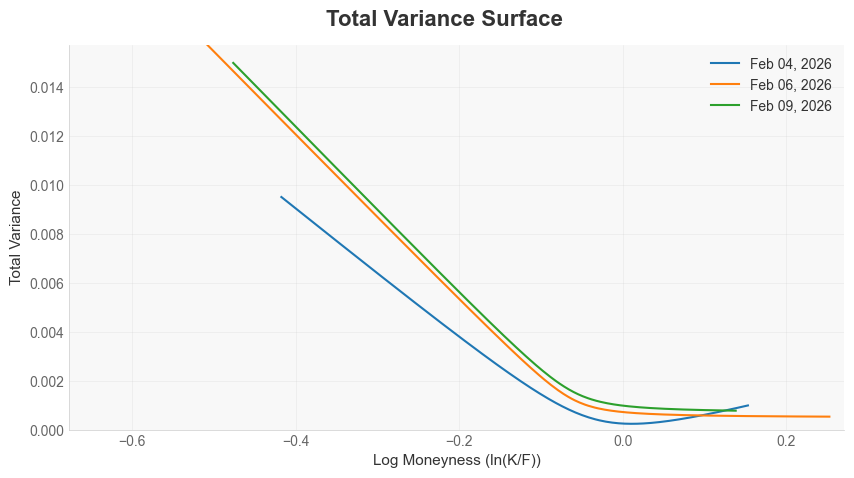

In [7]:
surface.plot()
plt.show()

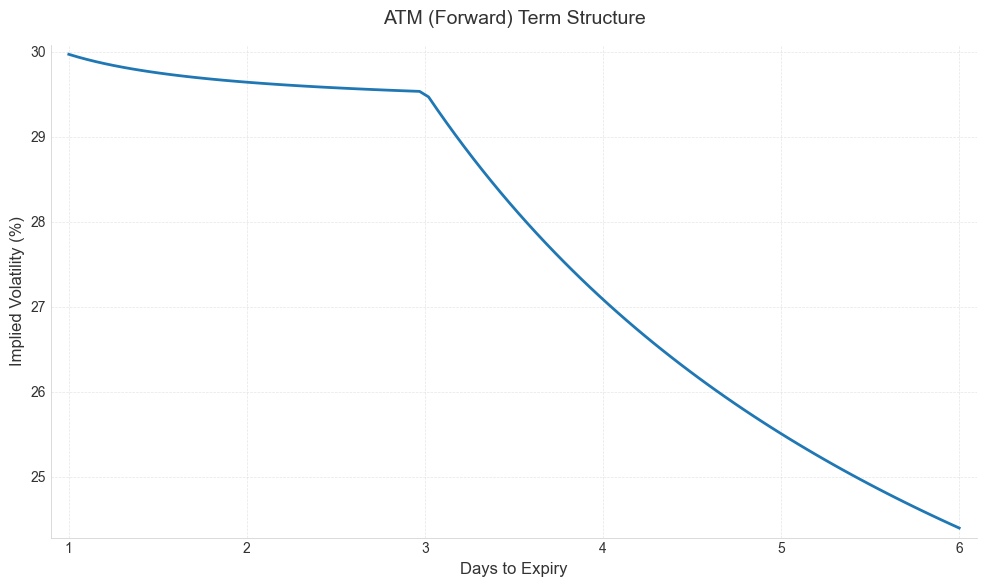

In [8]:
surface.plot_term_structure()
plt.show()

## ProbSurface fan chart

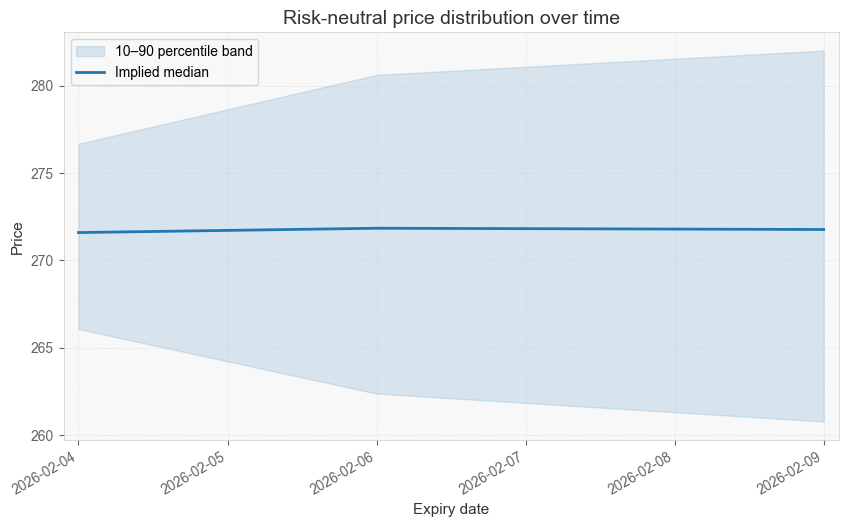

In [9]:
prob_surface = surface.implied_distribution()
prob_surface.plot_fan(lower_percentile=10.0, upper_percentile=90.0)
plt.show()

## Next steps

If you want a deeper tour of all methods (Greeks, quantiles, slicing, and
interpolation), use the AAPL CSV notebooks in `examples/`.